# **Práctica 1. Clustering de un frame con un coche. Dataset: Lidar**

- 128 planos con 1024 puntos cada uno
- El lidar está a 5.5 metros del suelo
- El eje Y es el eje vertical. Unas coordenadas "Y" negativas apuntan por encima del lidar
- El frame tiene un solo coche.

<img src="./screenshots/Portada_dataset_lidar.png" alt="Descripción" width="600"/>

## **Librerias**

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go
import open3d as o3d
from scipy.interpolate import interp1d

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

import glob
import cv2

import re
import shutil
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## **Lectura**

In [2]:
# Lectura de dataset .CSV. execution_mode = 1 si se ejecuta en local, 0 si se ejecuta en Google colab

def lectura(dataset):
  execution_mode = 1

  if(not execution_mode):
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv(f"/content/drive/MyDrive/Universidad/Master/Primer semestre/DISPDB/Practicas/Practica_1/datasets/{dataset}")

  else:
    df = pd.read_csv(f"{dataset}")

  return df

In [3]:
df = lectura("1_coche.csv").copy()
df.head(10)

,x,y,z,intensity,t,reflectivity,ring,ambient,range
0,-0.000000,0.000000,0.000000,0.0,1181241184,0,0,0,0
1,-0.000000,0.000000,0.000000,16.0,0,0,0,1470,0
2,-0.000000,0.000000,0.000000,13.0,49720,0,0,1025,0
3,-13.000649,2.733196,13.144561,14.0,99080,3,0,649,18670
4,-12.894675,2.793606,13.054574,12.0,150920,2,0,702,18542
5,-12.856470,2.868021,13.033484,23.0,194512,4,0,546,18512
6,-12.871898,2.954502,13.067228,17.0,248632,3,0,674,18560
7,-0.000000,0.000000,0.000000,11.0,293392,0,0,939,0
8,-0.000000,0.000000,0.000000,9.0,345232,0,0,772,0
9,-12.926430,3.218639,13.180415,11.0,392472,2,0,599,18721


In [4]:
df.info()
X = df.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   x             131072 non-null  float64
 1   y             131072 non-null  float64
 2   z             131072 non-null  float64
 3   intensity     131072 non-null  float64
 4   t             131072 non-null  int64  
 5   reflectivity  131072 non-null  int64  
 6   ring          131072 non-null  int64  
 7   ambient       131072 non-null  int64  
 8   range         131072 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 9.0 MB


## **EDA**

Se crea una nueva columna que identifique aquellos puntos que no vuelven al lidar (0,0,0)

In [5]:
import plotly.graph_objects as go

# Extraer las coordenadas y la intensidad
x = df['x'].values
y = df['y'].values
z = df['z'].values
intensity = df['intensity'].values

# Crear la figura 3D
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,  # Puedes ajustar el tamaño de los puntos aquí
        color=intensity,  # Colorear los puntos según la intensidad
        colorscale='hot',  # Mapa de colores para la intensidad
        colorbar=dict(title='Intensity')  # Barra de color
    )
)])

# Etiquetas de los ejes
fig.update_layout(
    scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        zaxis_title='Z Coordinate'
    ),
    title='3D Scatter Plot'
)

# Mostrar la gráfica
fig.show()

## **Preprocesado**


- **Filtrado**

In [6]:
def quartiles (df_cleaned):
    # -- SE ELIMINAN OUTLIERS .Calcular el primer cuartil (Q1) y el tercer cuartil (Q3) para cada columna
  Q1_x = df_cleaned['x'].quantile(0.15)
  Q3_x = df_cleaned['x'].quantile(0.85)
  IQR_x = Q3_x - Q1_x

  Q1_y = df_cleaned['y'].quantile(0.15)
  Q3_y = df_cleaned['y'].quantile(0.85)
  IQR_y = Q3_y - Q1_y

  Q1_z = df_cleaned['z'].quantile(0.15)
  Q3_z = df_cleaned['z'].quantile(0.85)
  IQR_z = Q3_z - Q1_z

  # -- SE DEFINEN LOS LIMITES SUPERIOR E INFERIOR
  lower_bound_x = Q1_x - 1.5 * IQR_x
  upper_bound_x = Q3_x + 1.5 * IQR_x

  lower_bound_y = Q1_y - 1.5 * IQR_y
  upper_bound_y = Q3_y + 1.5 * IQR_y

  lower_bound_z = Q1_z - 1.5 * IQR_z
  upper_bound_z = Q3_z + 1.5 * IQR_z

  df_cleaned = df_cleaned[
      (df_cleaned['x'] >= lower_bound_x) & (df_cleaned['x'] <= upper_bound_x) &
      (df_cleaned['y'] >= lower_bound_y) & (df_cleaned['y'] <= upper_bound_y) &
      (df_cleaned['z'] >= lower_bound_z) & (df_cleaned['z'] <= upper_bound_z)
  ]
  return df_cleaned

In [7]:
# -- Se eliminan los puntos infinitos (0.0,0.0,0.0)
def filtrado_puntos (df_cleaned, conditional_road, conditional_normalization):

  df_cleaned['Infinito'] = np.where((df_cleaned['x'] != 0) & (df_cleaned['x'] != -0) &
                       (df_cleaned['y'] != 0) & (df_cleaned['y'] != -0) &
                       (df_cleaned['z'] != 0) & (df_cleaned['z'] != -0),
                       '0', '1')
  
  df_cleaned['Infinito'] = df_cleaned['Infinito'].astype(int)
  df_cleaned = df_cleaned[(df_cleaned['x'].abs() != 0) & (df_cleaned['y'].abs() != 0) & (df_cleaned['z'].abs() != 0)]
  
  # -- SE ELIMINAN OUTLIERS .Calcular el primer cuartil (Q1) y el tercer cuartil (Q3) para cada columna
  df_cleaned = quartiles(df_cleaned)
  
  # -- SE ELIMINAN LOS PUNTOS CUYA "Y" SEA NEGATIVA
  df_cleaned = df_cleaned[(df_cleaned['y'] > 0)]

  # -- CONDICION PARA MANTENER O ELIMINAR LA CARRETERA
  if (conditional_road): 
    df_cleaned = df_cleaned[(df_cleaned['y'] > 3.5)] # -- SE LIMITA LA ALTURA A > 3, MANTENIENDO EL SUELO
  else:
    df_cleaned = df_cleaned[(df_cleaned['y'] > 3.5) & (df_cleaned['y'] < 5)] # -- SE ELIMINA LA CARRETERA
    df_cleaned = df_cleaned[(df_cleaned['x'] > -10)] # -- SE ELIMINA LA CARRETERA


  # -- SE ACOTA EL ANCHO DE LA CARRETERA, ELIMINANDO LOS LATERALES
  df_cleaned = df_cleaned[(df_cleaned['z'] > -4) & (df_cleaned['z'] < 4.5)]

  # -- CONDICION QUE NORMALIZA SI "conditional_normalization = 1"
  if(conditional_normalization):
    scaler = StandardScaler()
    df_cleaned[['x', 'y', 'z']] = scaler.fit_transform(df_cleaned[['x', 'y', 'z']])

  
  # df_cleaned.info(conditional_normalization)

  return df_cleaned

df_cleaned_con_carretera = df.copy()
df_cleaned_con_carretera = filtrado_puntos(df, 1, 0)

In [8]:
# Función para ajustar un plano a partir de los puntos de la carretera
def ajustar_plano(puntos):
    # Ajuste de un plano en la forma y = ax + bz + c
    X = puntos[['x', 'z']]
    Y = puntos['y']
    
    # Modelo de regresión lineal
    reg = LinearRegression()
    reg.fit(X, Y)
    
    a, b = reg.coef_
    c = reg.intercept_
    
    return a, b, c


# Función para filtrar puntos eliminando los que pertenecen a la carretera
def filtrado_puntos_con_pendiente(df_cleaned, conditional_normalization, margen_altura=0.5):

    df_cleaned['Infinito'] = np.where((df_cleaned['x'] != 0) & (df_cleaned['x'] != -0) &
                        (df_cleaned['y'] != 0) & (df_cleaned['y'] != -0) &
                        (df_cleaned['z'] != 0) & (df_cleaned['z'] != -0),
                        '0', '1')
    
    df_cleaned['Infinito'] = df_cleaned['Infinito'].astype(int)
    df_cleaned = df_cleaned[(df_cleaned['x'].abs() != 0) & (df_cleaned['y'].abs() != 0) & (df_cleaned['z'].abs() != 0)]
    
    
    
    # -- SE ELIMINAN LOS PUNTOS CUYA "Y" SEA NEGATIVA y que sea MAYOR de 3.5 para eliminar el sensor lidar.
    # -- SE ACOTA EL ANCHO DE LA CARRETERA, ELIMINANDO LOS LATERALES
    # -- SE ELIMINAN OUTLIERS .Calcular el primer cuartil (Q1) y el tercer cuartil (Q3) para cada columna
    df_cleaned = df_cleaned[(df_cleaned['y'] > 3.5)]
    df_cleaned = df_cleaned[(df_cleaned['z'] > -4) & (df_cleaned['z'] < 4.5)]
    df_cleaned = quartiles(df_cleaned)

    # -- PLANO: Se asume que los puntos de la carretera están en un rango de 'y' (altura)
    carretera_puntos = df_cleaned[(df_cleaned['y'] > 3.5) & (df_cleaned['y'] < 7)].copy()
    
    a, b, c = ajustar_plano(carretera_puntos)
    
    # Función que evalúa si un punto está cerca del plano ajustado
    def esta_cerca_del_plano(fila):
        x, z, y = fila['x'], fila['z'], fila['y']
        y_plano = a * x + b * z + c  # Ecuación del plano
        return (y_plano - margen_altura) <= y <= (y_plano + margen_altura)
    
    # Se filtran los puntos que no están cerca del plano (estos serán los vehículos o elementos no parte de la carretera)
    df_cleaned['Cerca_del_plano'] = df_cleaned.apply(esta_cerca_del_plano, axis=1)
    df_filtrado = df_cleaned[~df_cleaned['Cerca_del_plano']]
    
    # Se eliminan la columna auxiliar
    df_filtrado = df_filtrado.drop(columns=['Cerca_del_plano'])


    if conditional_normalization:
        scaler = StandardScaler()
        df_filtrado[['x', 'y', 'z']] = scaler.fit_transform(df_filtrado[['x', 'y', 'z']])

    return df_filtrado

In [9]:
##### ESTA CELDA ES PARA MOSTRAR CON OPEN3D #####

def mostrar_dataset_open3d(df):
    x = df['x'].values
    y = df['y'].values
    z = df['z'].values
    intensity = df['intensity'].values

    pcd = o3d.geometry.PointCloud()

    # Se combinan las coordenadas en un array de forma (n, 3)
    points = np.vstack((x, y, z)).T
    pcd.points = o3d.utility.Vector3dVector(points)

    # Se normaliza la intensidad a [0, 1] para los colores
    normalized_intensity = (intensity - np.min(intensity)) / (np.max(intensity) - np.min(intensity))

    # Se crean colores en formato RGB (escala de colores 'hot')
    colors = plt.cm.hot(normalized_intensity)[:, :3] 
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # La rotación se aplica alrededor del eje X en 90 grados (o el eje Y según el caso)
    R = pcd.get_rotation_matrix_from_xyz((np.pi / 0.3, 0, 0))  # Rotación de 90 grados en el eje X
    pcd.rotate(R, center=(0, 0, 0))  # Aplicar la rotación alrededor del origen

    # Visualizacion de nube de puntos
    o3d.visualization.draw_geometries([pcd], window_name='Nube de Puntos')

mostrar_dataset_open3d(df_cleaned_con_carretera)

<img src="./screenshots/1_coche_preprocesadoVisualization.png" alt="Descripción" width="600"/>

## **Modelos**

In [27]:
# -- FUNCIÓN QUE DEFINE EL MODELO DBSCAN Y MUESTRA EL RESULTADO DE LOS CLUSTERING CON OPEN3D

def DBSCAN_open3d(df__visualization, df_cleaned, epsilon, min_samples):

    x = df__visualization['x'].values
    y = df__visualization['y'].values
    z = df__visualization['z'].values


    pcd = o3d.geometry.PointCloud()
    points = np.vstack((x, y, z)).T

    # ---------------------------------
    # -- Configurar y aplicar DBSCAN --
    # ---------------------------------

    X_train = df_cleaned.to_numpy()

    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    y_dbscan = dbscan.fit_predict(X_train[:, 0:3])

    pcd = o3d.geometry.PointCloud() # Crear una nube de puntos para Open3D
    pcd.points = o3d.utility.Vector3dVector(points)

    # Asignar colores a cada clúster
    unique_labels = np.unique(y_dbscan)
    num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Excluir el ruido (-1)
    print(f"Número de clústeres encontrados (sin incluir el ruido): {num_clusters}")

    # Cada clúster tendrá un color diferente, y el ruido (-1) será rojo
    colormap = plt.cm.get_cmap("tab20", num_clusters)  # Usa 'tab20' para hasta 20 clústeres
    colors = np.zeros((len(y_dbscan), 3))  # Array de colores

    for i, label in enumerate(y_dbscan):
        if label == -1:
            
            colors[i] = [1, 0, 0]  # Rojo: ruido
        else:
            colors[i] = colormap(label % num_clusters)[:3]  # Ignorar alfa, solo RGB

    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Se aplica una rotación para alinear la carretera correctamente
    R = pcd.get_rotation_matrix_from_xyz((np.pi / 0.3, 0, 0))  # Rotación de 45 grados en el eje X (puedes ajustarla)
    pcd.rotate(R, center=(0, 0, 0))  # Aplicar la rotación alrededor del origen

    o3d.visualization.draw_geometries([pcd], window_name='Clústeres DBSCAN')


In [28]:
# -- FUNCIÓN QUE DEFINE EL MODELO KMEANS Y MUESTRA EL RESULTADO DE LOS CLUSTERING CON OPEN3D
def KMEANS_open3d(df__visualization, df_cleaned_con_carretera, n_clusters):

    x = df__visualization['x'].values
    y = df__visualization['y'].values
    z = df__visualization['z'].values

    pcd = o3d.geometry.PointCloud()
    points = np.vstack((x, y, z)).T
    pcd.points = o3d.utility.Vector3dVector(points)

    # ---------------------------------
    # -- Configurar y aplicar KMeans --
    # ---------------------------------

    X_train = df_cleaned_con_carretera.to_numpy()

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X_train[:,0:3])

    centroides = kmeans.cluster_centers_  # Coordenadas de los centroides
    etiquetas = kmeans.labels_  # Etiquetas de los clústeres para cada punto

    # Se asignan colores a cada clúster
    unique_labels = np.unique(etiquetas)
    num_clusters = len(unique_labels)

    print(f"Numero de clusters: {num_clusters}")

    # Se crea un colormap para los clústeres
    colormap = plt.cm.get_cmap("tab20", num_clusters)  # Usa 'tab20' para hasta 20 clústeres
    colors = np.zeros((len(etiquetas), 3))  # Array de colores para cada punto

    for i, label in enumerate(etiquetas):
        colors[i] = colormap(label % num_clusters)[:3]  # Asignamos color según la etiqueta

    pcd.colors = o3d.utility.Vector3dVector(colors)  # Asignamos los colores a los puntos

    # Se visualizan los centroides como esferas
    centroid_pcd = o3d.geometry.PointCloud()
    centroid_pcd.points = o3d.utility.Vector3dVector(centroides)

    # Se crean esferas para los centroides
    centroid_spheres = []
    for centroid in centroides:
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.1)
        sphere.paint_uniform_color([1, 0, 0])  # Color rojo para los centroides
        sphere.translate(centroid)
        centroid_spheres.append(sphere)

    # Se aplican una rotación para alinear la carretera correctamente
    R = pcd.get_rotation_matrix_from_xyz((np.pi / 0.3, 0, 0)) 
    pcd.rotate(R, center=(0, 0, 0))

    # Se visualizan los puntos y los centroides
    o3d.visualization.draw_geometries([pcd, *centroid_spheres], window_name='KMeans Clusters and Centroids')

## **Resultados** dataset Un coche 

### **Lectura y Preprocesado**

In [263]:
# -- Lectura
df = lectura("1_coche.csv").copy()
df.head(10)

,x,y,z,intensity,t,reflectivity,ring,ambient,range
0,-0.000000,0.000000,0.000000,0.0,1181241184,0,0,0,0
1,-0.000000,0.000000,0.000000,16.0,0,0,0,1470,0
2,-0.000000,0.000000,0.000000,13.0,49720,0,0,1025,0
3,-13.000649,2.733196,13.144561,14.0,99080,3,0,649,18670
4,-12.894675,2.793606,13.054574,12.0,150920,2,0,702,18542
5,-12.856470,2.868021,13.033484,23.0,194512,4,0,546,18512
6,-12.871898,2.954502,13.067228,17.0,248632,3,0,674,18560
7,-0.000000,0.000000,0.000000,11.0,293392,0,0,939,0
8,-0.000000,0.000000,0.000000,9.0,345232,0,0,772,0
9,-12.926430,3.218639,13.180415,11.0,392472,2,0,599,18721


In [264]:
df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 0).copy()
mostrar_dataset_open3d(df_cleaned_con_carretera)

### **DBScan** con la carretera

Estudiamos el mejor epsilon. Un valor epsilon que permita una proporcion grande en torno al 90% de que todas las muestras tengan al menos un vecino mas cercano inferior a epsilon. Se usa NearestNeighbors.

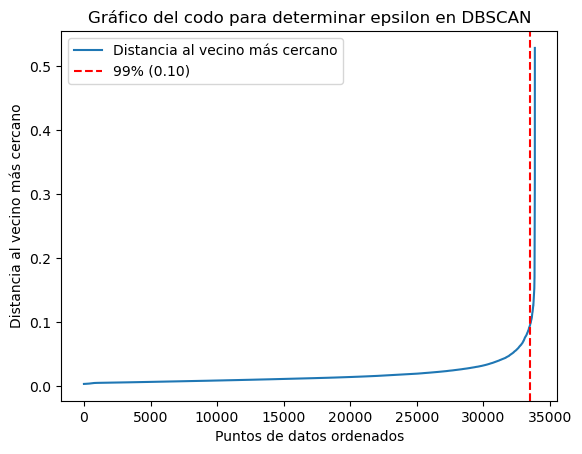

In [265]:
df__visualization = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 0).copy()

df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 1).copy()
X = df_cleaned_con_carretera[['x', 'y', 'z']].to_numpy()

nearest_neighbors = NearestNeighbors(n_neighbors=2)  # Buscamos el vecino más cercano (sin contar el propio punto)
neighbors_fit = nearest_neighbors.fit(X)

distances, indices = neighbors_fit.kneighbors(X)

# Ordenar las distancias para trazar la gráfica del codo
distances = np.sort(distances[:, 1])  # Solo tomamos la segunda columna porque la primera es la distancia a sí mismo
percentile_99_value = np.percentile(distances, 99)

# Encontrar el índice donde se alcanza el percentil 99 en las distancias ordenadas
percentile_99_index = np.where(distances <= percentile_99_value)[0][-1]

plt.plot(distances, label='Distancia al vecino más cercano')
plt.axvline(x=percentile_99_index, color='r', linestyle='--', label=f'99% ({percentile_99_value:.2f})')
plt.xlabel('Puntos de datos ordenados')
plt.ylabel('Distancia al vecino más cercano')
plt.title('Gráfico del codo para determinar epsilon en DBSCAN')
plt.legend()

# Mostrar la gráfica
plt.show()

In [266]:
df_cleaned_con_carretera.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33865 entries, 9425 to 113970
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   x             33865 non-null  float64
 1   y             33865 non-null  float64
 2   z             33865 non-null  float64
 3   intensity     33865 non-null  float64
 4   t             33865 non-null  int64  
 5   reflectivity  33865 non-null  int64  
 6   ring          33865 non-null  int64  
 7   ambient       33865 non-null  int64  
 8   range         33865 non-null  int64  
 9   Infinito      33865 non-null  int32  
dtypes: float64(4), int32(1), int64(5)
memory usage: 2.7 MB


Se aplica el algoritmo DBSCAN

In [267]:
DBSCAN_open3d(df__visualization=df__visualization, df_cleaned=df_cleaned_con_carretera, epsilon=0.30, min_samples=7)

Número de clústeres encontrados (sin incluir el ruido): 2


C:\Users\jorge\AppData\Local\Temp\ipykernel_6924\2590551292.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/1_coche_DBScan_conCarretera.png" alt="Descripción" width="600"/>

- Se concluye que el algoritmo DBScan con una epsilon = 0.30 y min_vecinos = 7 separa en dos clustering la carretera y el coche. El "elbow method" no es preciso por la distribucion de los puntos; hay mas puntos en la carretera que en el coche.


### **DBScan** sin carretera
- Mejora: se elimina la carretera del dataset
- Estudiamos el mejor epsilon. Un valor epsilon que permita una proporcion grande en torno al 90% de que todas las muestras tengan al menos un vecino mas cercano inferior a epsilon. Se usa NearestNeighbors.

In [268]:
df__visualization = filtrado_puntos(df, conditional_road = 0, conditional_normalization = 0).copy()
df_cleaned_sin_carretera = filtrado_puntos(df, conditional_road = 0, conditional_normalization = 1).copy()
mostrar_dataset_open3d(df__visualization)

In [269]:
df_cleaned_sin_carretera.head(5)

,x,y,z,intensity,t,reflectivity,ring,ambient,range,Infinito
24754,-0.604293,-0.057925,2.196592,687.0,8649544,16,24,7571,5182,0
24755,-0.577087,-0.045627,2.189624,829.0,8696784,19,24,4690,5175,0
24756,-0.580976,0.399841,2.304103,323.0,8743344,6,24,1549,5290,0
24757,-0.556205,0.454166,2.309080,912.0,8793344,22,24,1758,5295,0
24804,0.706993,1.340620,2.306094,395.0,11087728,8,24,4097,5292,0


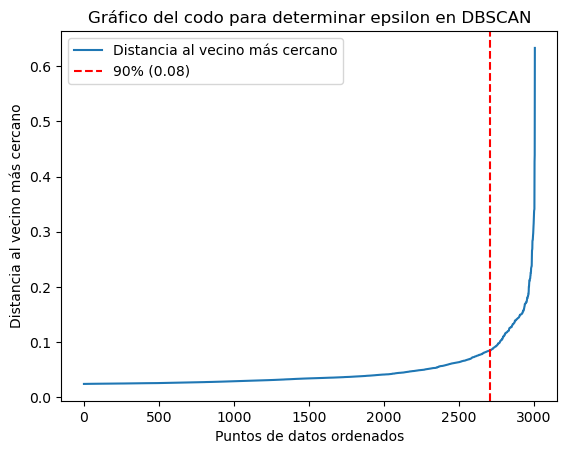

In [270]:
X = df_cleaned_sin_carretera[['x', 'y', 'z']].to_numpy()

nearest_neighbors = NearestNeighbors(n_neighbors=2)  # Buscamos el vecino más cercano (sin contar el propio punto)
neighbors_fit = nearest_neighbors.fit(X)

distances, indices = neighbors_fit.kneighbors(X)

# Ordenar las distancias para trazar la gráfica del codo
distances = np.sort(distances[:, 1])  # Solo tomamos la segunda columna porque la primera es la distancia a sí mismo
percentile_90_value = np.percentile(distances, 90)

# Encontrar el índice donde se alcanza el percentil 90 en las distancias ordenadas
percentile_90_index = np.where(distances <= percentile_90_value)[0][-1]

plt.plot(distances, label='Distancia al vecino más cercano')
plt.axvline(x=percentile_90_index, color='r', linestyle='--', label=f'90% ({percentile_90_value:.2f})')
plt.xlabel('Puntos de datos ordenados')
plt.ylabel('Distancia al vecino más cercano')
plt.title('Gráfico del codo para determinar epsilon en DBSCAN')
plt.legend()

# Mostrar la gráfica
plt.show()

In [271]:
DBSCAN_open3d(df__visualization=df__visualization, df_cleaned=df_cleaned_sin_carretera, epsilon=0.60, min_samples=7)

Número de clústeres encontrados (sin incluir el ruido): 1


C:\Users\jorge\AppData\Local\Temp\ipykernel_6924\2590551292.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/1_coche_DBScan_sinCarretera.png" alt="Descripción" width="600"/>

- Se concluye que el algoritmo DBScan con una epsilon = 0.60 y min_vecinos = 7 separa en dos clustering la carretera y el coche. El "elbow method" no es preciso por la distribucion de los puntos; hay mas puntos en el techo del coche que en la zona de debajo. Un epsilon por debajo de 0.60 genera varios clusters de más para un mismo coche.


### **k-MEANS** con carretera

In [272]:
df__visualization = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 0).copy()
df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 1).copy()

KMEANS_open3d(df__visualization, df_cleaned_con_carretera, n_clusters = 2)

j:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Numero de clusters: 2


C:\Users\jorge\AppData\Local\Temp\ipykernel_6924\4000080866.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/1_coche_Kmeans_conCarretera.png" alt="Descripción" width="600"/>

- Se concluye que el algoritmo Kmeans con 2 clusters no separa correctamente la carretera del coche.

### **k-MEANS** sin carretera

In [273]:
df__visualization = filtrado_puntos(df, conditional_road = 0, conditional_normalization = 0).copy()
df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 0, conditional_normalization = 1).copy()

KMEANS_open3d(df__visualization, df_cleaned_con_carretera, n_clusters = 1)

j:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Numero de clusters: 1


C:\Users\jorge\AppData\Local\Temp\ipykernel_6924\4000080866.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/1_coche_Kmeans_sinCarretera.png" alt="Descripción" width="600"/>

- El Kmeans detecta el coche con un solo cluster

## **Resultados** dataset Dos Coches

### **Lectura y Preprocesado**

In [276]:
# -- Lectura
df = lectura("coche_coche.csv").copy()
df.head(10)

,x,y,z,intensity,t,reflectivity,ring,ambient,range
0,-0.000000,0.000000,0.000000,0.0,2601586312,0,0,0,0
1,-0.000000,0.000000,0.000000,16.0,0,0,0,1371,0
2,-0.000000,0.000000,0.000000,10.0,49880,0,0,990,0
3,-13.103642,2.754890,13.248608,12.0,93760,2,0,776,18818
4,-13.000313,2.816535,13.161433,14.0,146600,3,0,773,18694
5,-12.969600,2.893304,13.148076,17.0,193440,3,0,540,18675
6,-12.939127,2.969961,13.135422,17.0,246040,3,0,639,18657
7,-0.000000,0.000000,0.000000,14.0,294320,0,0,1017,0
8,-0.000000,0.000000,0.000000,10.0,339840,0,0,816,0
9,-12.905728,3.213476,13.159324,18.0,386080,3,0,686,18691


In [277]:
df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 0).copy()
mostrar_dataset_open3d(df_cleaned_con_carretera)

### **DBScan** con la carretera

Estudiamos el mejor epsilon. Un valor epsilon que permita una proporcion grande en torno al 90% de que todas las muestras tengan al menos un vecino mas cercano inferior a epsilon. Se usa NearestNeighbors.

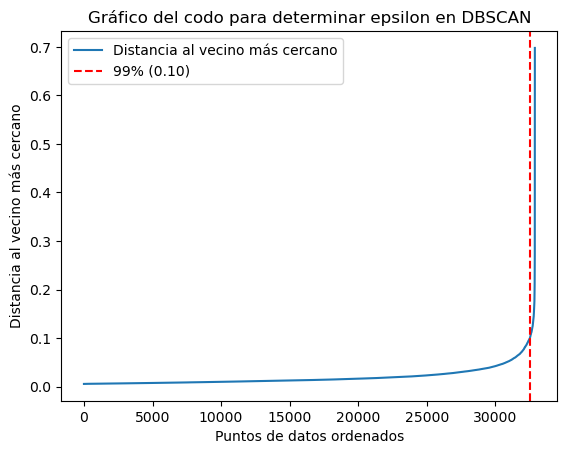

In [254]:
df__visualization = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 0).copy()

df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 1).copy()
X = df_cleaned_con_carretera[['x', 'y', 'z']].to_numpy()

nearest_neighbors = NearestNeighbors(n_neighbors=2)  # Buscamos el vecino más cercano (sin contar el propio punto)
neighbors_fit = nearest_neighbors.fit(X)

distances, indices = neighbors_fit.kneighbors(X)

# Ordenar las distancias para trazar la gráfica del codo
distances = np.sort(distances[:, 1])  # Solo tomamos la segunda columna porque la primera es la distancia a sí mismo
percentile_99_value = np.percentile(distances, 99)

# Encontrar el índice donde se alcanza el percentil 99 en las distancias ordenadas
percentile_99_index = np.where(distances <= percentile_99_value)[0][-1]

plt.plot(distances, label='Distancia al vecino más cercano')
plt.axvline(x=percentile_99_index, color='r', linestyle='--', label=f'99% ({percentile_99_value:.2f})')
plt.xlabel('Puntos de datos ordenados')
plt.ylabel('Distancia al vecino más cercano')
plt.title('Gráfico del codo para determinar epsilon en DBSCAN')
plt.legend()

# Mostrar la gráfica
plt.show()

In [255]:
df_cleaned_con_carretera.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32875 entries, 9425 to 113972
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   x             32875 non-null  float64
 1   y             32875 non-null  float64
 2   z             32875 non-null  float64
 3   intensity     32875 non-null  float64
 4   t             32875 non-null  int64  
 5   reflectivity  32875 non-null  int64  
 6   ring          32875 non-null  int64  
 7   ambient       32875 non-null  int64  
 8   range         32875 non-null  int64  
 9   Infinito      32875 non-null  int32  
dtypes: float64(4), int32(1), int64(5)
memory usage: 2.6 MB


Se aplica el algoritmo DBSCAN

In [257]:
DBSCAN_open3d(df__visualization=df__visualization, df_cleaned=df_cleaned_con_carretera, epsilon=0.27, min_samples=30)

Número de clústeres encontrados (sin incluir el ruido): 3


C:\Users\jorge\AppData\Local\Temp\ipykernel_6924\2590551292.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/coche_coche_DBScan_conCarretera.png" alt="Descripción" width="600"/>

- El algoritmo separa en 3 clusterings la carretera y los dos coches. Se ha calculado el epsilon y min_vecinos mediante prueba y error.

### **DBScan** sin carretera
- Mejora: se elimina la carretera del dataset
- Estudiamos el mejor epsilon. Un valor epsilon que permita una proporcion grande en torno al 90% de que todas las muestras tengan al menos un vecino mas cercano inferior a epsilon. Se usa NearestNeighbors.

In [258]:
df__visualization = filtrado_puntos(df, conditional_road = 0, conditional_normalization = 0).copy()
df_cleaned_sin_carretera = filtrado_puntos(df, conditional_road = 0, conditional_normalization = 1).copy()
mostrar_dataset_open3d(df__visualization)

In [259]:
df_cleaned_sin_carretera.head(5)

,x,y,z,intensity,t,reflectivity,ring,ambient,range,Infinito
36007,0.073655,0.494511,1.257469,102.0,8106752,6,35,4015,6243,0
36008,0.085979,0.616833,1.261116,149.0,8159912,8,35,4708,6261,0
36009,0.109311,0.677191,1.259698,201.0,8208192,11,35,5269,6254,0
36010,0.157970,0.590139,1.246326,267.0,8253952,14,35,5672,6188,0
36011,0.189296,0.600801,1.241059,328.0,8305912,18,35,5878,6162,0


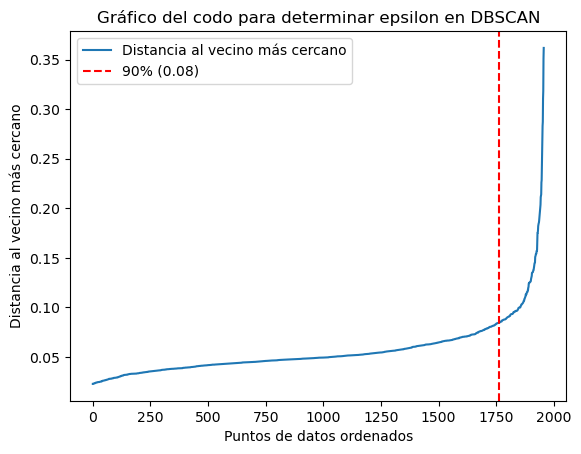

In [260]:
X = df_cleaned_sin_carretera[['x', 'y', 'z']].to_numpy()

nearest_neighbors = NearestNeighbors(n_neighbors=2)  # Buscamos el vecino más cercano (sin contar el propio punto)
neighbors_fit = nearest_neighbors.fit(X)

distances, indices = neighbors_fit.kneighbors(X)

# Ordenar las distancias para trazar la gráfica del codo
distances = np.sort(distances[:, 1])  # Solo tomamos la segunda columna porque la primera es la distancia a sí mismo
percentile_90_value = np.percentile(distances, 90)

# Encontrar el índice donde se alcanza el percentil 90 en las distancias ordenadas
percentile_90_index = np.where(distances <= percentile_90_value)[0][-1]

plt.plot(distances, label='Distancia al vecino más cercano')
plt.axvline(x=percentile_90_index, color='r', linestyle='--', label=f'90% ({percentile_90_value:.2f})')
plt.xlabel('Puntos de datos ordenados')
plt.ylabel('Distancia al vecino más cercano')
plt.title('Gráfico del codo para determinar epsilon en DBSCAN')
plt.legend()

# Mostrar la gráfica
plt.show()

In [261]:
DBSCAN_open3d(df__visualization=df__visualization, df_cleaned=df_cleaned_sin_carretera, epsilon=0.60, min_samples=7)

Número de clústeres encontrados (sin incluir el ruido): 2


C:\Users\jorge\AppData\Local\Temp\ipykernel_6924\2590551292.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/coche_coche_DBScan_sinCarretera.png" alt="Descripción" width="600"/>

- Se concluye que el algoritmo DBScan con una epsilon = 0.60 y min_vecinos = 7 separa en dos clustering ambos coches correctamente.


### **k-MEANS** con carretera

In [283]:
df__visualization = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 0).copy()
df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 1).copy()

KMEANS_open3d(df__visualization, df_cleaned_con_carretera, n_clusters = 3)

j:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Numero de clusters: 3


C:\Users\jorge\AppData\Local\Temp\ipykernel_6924\4000080866.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/coche_coche_Kmeans_conCarretera.png" alt="Descripción" width="600"/>

- Se concluye que el algoritmo Kmeans con 2 clusters no separa correctamente la carretera del coche.

### **k-MEANS** sin carretera

In [280]:
df__visualization = filtrado_puntos(df, conditional_road = 0, conditional_normalization = 0).copy()
df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 0, conditional_normalization = 1).copy()

KMEANS_open3d(df__visualization, df_cleaned_con_carretera, n_clusters = 2)

j:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Numero de clusters: 2


C:\Users\jorge\AppData\Local\Temp\ipykernel_6924\4000080866.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/coche_coche_Kmeans_sinCarretera.png" alt="Descripción" width="600"/>

- El Kmeans detecta ambos coches con dos clusters en un dataset filtrado sin carretera

## **Resultados** dataset Dos Coches y una moto

### **Lectura y Preprocesado**

In [22]:
# -- Lectura
df = lectura("coche_coche_moto.csv").copy()
df.head(10)

,x,y,z,intensity,t,reflectivity,ring,ambient,range
0,-0.000000,0.000000,0.000000,0.0,3881424416,0,0,0,0
1,-0.000000,0.000000,0.000000,12.0,0,0,0,1479,0
2,-0.000000,0.000000,0.000000,9.0,50880,0,0,927,0
3,-13.082068,2.750346,13.226814,25.0,98280,5,0,673,18787
4,-0.000000,0.000000,0.000000,10.0,148160,0,0,726,0
5,-12.923793,2.883066,13.101676,13.0,194280,2,0,524,18609
6,-12.915563,2.964542,13.111519,21.0,244200,4,0,599,18623
7,-0.000000,0.000000,0.000000,9.0,292880,0,0,915,0
8,-0.000000,0.000000,0.000000,9.0,344160,0,0,760,0
9,-12.931260,3.219843,13.185336,22.0,392520,4,0,593,18728


In [23]:
df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 0).copy()
mostrar_dataset_open3d(df_cleaned_con_carretera)

### **DBScan** con la carretera

Estudiamos el mejor epsilon. Un valor epsilon que permita una proporcion grande en torno al 90% de que todas las muestras tengan al menos un vecino mas cercano inferior a epsilon. Se usa NearestNeighbors.

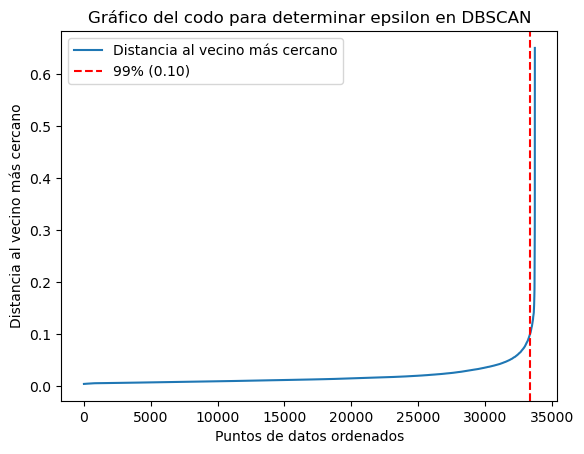

In [94]:
df__visualization = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 0).copy()

df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 1).copy()
X = df_cleaned_con_carretera[['x', 'y', 'z']].to_numpy()

nearest_neighbors = NearestNeighbors(n_neighbors=2)  # Buscamos el vecino más cercano (sin contar el propio punto)
neighbors_fit = nearest_neighbors.fit(X)

distances, indices = neighbors_fit.kneighbors(X)

# Ordenar las distancias para trazar la gráfica del codo
distances = np.sort(distances[:, 1])  # Solo tomamos la segunda columna porque la primera es la distancia a sí mismo
percentile_99_value = np.percentile(distances, 99)

# Encontrar el índice donde se alcanza el percentil 99 en las distancias ordenadas
percentile_99_index = np.where(distances <= percentile_99_value)[0][-1]

plt.plot(distances, label='Distancia al vecino más cercano')
plt.axvline(x=percentile_99_index, color='r', linestyle='--', label=f'99% ({percentile_99_value:.2f})')
plt.xlabel('Puntos de datos ordenados')
plt.ylabel('Distancia al vecino más cercano')
plt.title('Gráfico del codo para determinar epsilon en DBSCAN')
plt.legend()

# Mostrar la gráfica
plt.show()

In [25]:
df_cleaned_con_carretera.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33731 entries, 9424 to 113970
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   x             33731 non-null  float64
 1   y             33731 non-null  float64
 2   z             33731 non-null  float64
 3   intensity     33731 non-null  float64
 4   t             33731 non-null  int64  
 5   reflectivity  33731 non-null  int64  
 6   ring          33731 non-null  int64  
 7   ambient       33731 non-null  int64  
 8   range         33731 non-null  int64  
 9   Infinito      33731 non-null  int32  
dtypes: float64(4), int32(1), int64(5)
memory usage: 2.7 MB


Se aplica el algoritmo DBSCAN

In [168]:
DBSCAN_open3d(df__visualization=df__visualization, df_cleaned=df_cleaned_con_carretera, epsilon=0.23, min_samples=4)

Número de clústeres encontrados (sin incluir el ruido): 3


C:\Users\jorge\AppData\Local\Temp\ipykernel_19100\2590551292.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/coche_coche_moto_DBSCAN_conCarretera.png" alt="Descripción" width="600"/>

- No se ha alcanzado una configuracion de epsilon y min_samples con la que separar los dos coches, la moto y la carretera

### **DBScan** sin carretera
- Mejora: se elimina la carretera del dataset
- Estudiamos el mejor epsilon. Un valor epsilon que permita una proporcion grande en torno al 90% de que todas las muestras tengan al menos un vecino mas cercano inferior a epsilon. Se usa NearestNeighbors.

In [230]:
df__visualization = filtrado_puntos_con_pendiente(df, conditional_normalization = 0).copy()
df_cleaned_sin_carretera = filtrado_puntos_con_pendiente(df, conditional_normalization = 1).copy()
mostrar_dataset_open3d(df__visualization)

In [ ]:
df_cleaned_sin_carretera.head(5)

,x,y,z,intensity,t,reflectivity,ring,ambient,range,Infinito
36007,0.073655,0.494511,1.257469,102.0,8106752,6,35,4015,6243,0
36008,0.085979,0.616833,1.261116,149.0,8159912,8,35,4708,6261,0
36009,0.109311,0.677191,1.259698,201.0,8208192,11,35,5269,6254,0
36010,0.157970,0.590139,1.246326,267.0,8253952,14,35,5672,6188,0
36011,0.189296,0.600801,1.241059,328.0,8305912,18,35,5878,6162,0


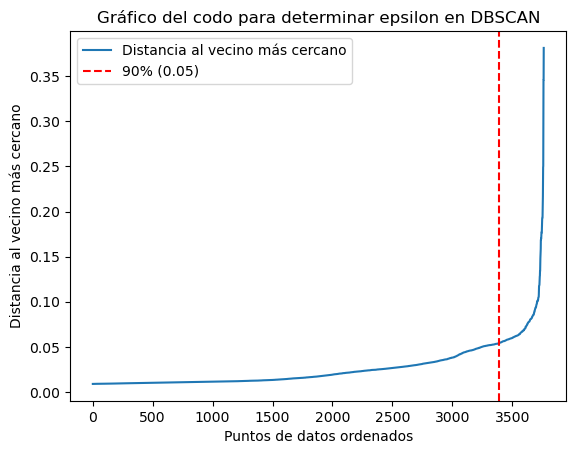

In [231]:
X = df_cleaned_sin_carretera[['x', 'y', 'z']].to_numpy()

nearest_neighbors = NearestNeighbors(n_neighbors=2)  # Buscamos el vecino más cercano (sin contar el propio punto)
neighbors_fit = nearest_neighbors.fit(X)

distances, indices = neighbors_fit.kneighbors(X)

# Ordenar las distancias para trazar la gráfica del codo
distances = np.sort(distances[:, 1])  # Solo tomamos la segunda columna porque la primera es la distancia a sí mismo
percentile_90_value = np.percentile(distances, 90)

# Encontrar el índice donde se alcanza el percentil 90 en las distancias ordenadas
percentile_90_index = np.where(distances <= percentile_90_value)[0][-1]

plt.plot(distances, label='Distancia al vecino más cercano')
plt.axvline(x=percentile_90_index, color='r', linestyle='--', label=f'90% ({percentile_90_value:.2f})')
plt.xlabel('Puntos de datos ordenados')
plt.ylabel('Distancia al vecino más cercano')
plt.title('Gráfico del codo para determinar epsilon en DBSCAN')
plt.legend()

# Mostrar la gráfica
plt.show()

In [233]:
DBSCAN_open3d(df__visualization=df__visualization, df_cleaned=df_cleaned_sin_carretera, epsilon=0.60, min_samples=7)

Número de clústeres encontrados (sin incluir el ruido): 3


C:\Users\jorge\AppData\Local\Temp\ipykernel_19100\2590551292.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/coche_coche_moto_DBSCAN_sinCarretera.png" alt="Descripción" width="600"/>

- Se concluye que el algoritmo DBScan con una epsilon = 0.60 y min_vecinos = 7 separa en 3 clusters los vehiculos, siempre que se elimine la carretera mediante la interseccion de un plano.


### **k-MEANS** con carretera

In [235]:
df__visualization = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 0).copy()
df_cleaned_con_carretera = filtrado_puntos(df, conditional_road = 1, conditional_normalization = 1).copy()

KMEANS_open3d(df__visualization, df_cleaned_con_carretera, n_clusters = 4)

j:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Numero de clusters: 4


C:\Users\jorge\AppData\Local\Temp\ipykernel_19100\4000080866.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/coche_coche_moto_Kmeans_conCarretera.png" alt="Descripción" width="600"/>

- Se concluye que el algoritmo Kmeans con 4 clusters no separa correctamente la carretera del coche y moto.

### **k-MEANS** sin carretera

In [236]:
df__visualization = filtrado_puntos_con_pendiente(df, conditional_normalization = 0).copy()
df_cleaned_con_carretera = filtrado_puntos_con_pendiente(df, conditional_normalization = 1).copy()

KMEANS_open3d(df__visualization, df_cleaned_con_carretera, n_clusters = 3)

j:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Numero de clusters: 3


C:\Users\jorge\AppData\Local\Temp\ipykernel_19100\4000080866.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<img src="./screenshots/coche_coche_moto_Kmeans_sinCarretera.png" alt="Descripción" width="600"/>

- El Kmeans detecta lso 3 vehiculos con 3 clusters en un dataset filtrado sin carretera mediante un plano

## **Tracking**

### Funciones auxiliares

En primer lugar, se transforman los nombres de los .csv para que todos tengan la misma longitud y estén ordenados.

In [10]:
clusters_data_path = './'  # Ruta relativa
original_folder = os.path.join(clusters_data_path, 'pointclouds')
new_folder = os.path.join(clusters_data_path, 'ordered_pointclouds')

if not os.path.exists(new_folder):
    os.makedirs(new_folder)

files = [f for f in os.listdir(original_folder) if f.endswith('.csv')]

def names(filename):
    match = re.search(r'pointcloud_(\d+)_(\d+)\.csv', filename)
    if match:
        return match.group(1), match.group(2)
    return None

max_len_second_part = max(len(names(f)[1]) for f in files)


def normalize(filename):
    first_part, second_part = names(filename)
    padded_second_part = second_part.zfill(max_len_second_part)
    return f'pointcloud_{first_part}_{padded_second_part}.csv'

sorted_files = sorted(files, key=lambda x: normalize(x))

for file in sorted_files:
    src = os.path.join(original_folder, file)
    dst = os.path.join(new_folder, file)
    shutil.copy(src, dst)

Se define la función para crear un vídeo: 

In [11]:
# Función para crear un video a partir de imágenes capturadas
def crear_video(output_path, image_folder, frame_rate=10):
    images = sorted(glob.glob(os.path.join(image_folder, '*.png')))
    if not images:
        print("No se encontraron imágenes para crear el video.")
        return

    # Leer la primera imagen para obtener las dimensiones del video
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape

    # Inicializar el archivo de video
    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (width, height))

    # Agregar todas las imágenes al video
    for image in images:
        video.write(cv2.imread(image))

    video.release()
    print(f"Video guardado en: {output_path}")

### Algoritmo de Tracking

Se recorren los frames y se envían al servicio DBSCAN open3d para calcular los clusters. Una vez se etiquetan la nube de puntos con los clusters, a cada cluster se le asocia un color. La función oriented_bbox() permite calcular "boundary boxes" sobre los clusters.

In [12]:
# Función para calcular y agregar cajas delimitadoras (Bounding Boxes) alrededor de clusters
def oriented_bbox(pcd, labels, min_points=30, max_points=400):
    obbs = []
    # Agrupar índices por etiquetas de clusters
    indices = pd.Series(range(len(labels))).groupby(labels, sort=False).apply(list).tolist()

    print(f"Numero de cluster: f{len(indices)}")

    # Iterar sobre los clusters y calcular bounding boxes
    for i in range(len(indices)):
        sub_cloud = pcd.select_by_index(indices[i])
        num_points = len(sub_cloud.points)
        
        # Aplicar límite en el tamaño de los clusters a incluir
        if min_points < num_points < max_points:
            obb = sub_cloud.get_axis_aligned_bounding_box()
            obb.color = (0, 0, 0)  # Color negro para las Bounding Boxes
            obbs.append(obb)

    print(f"Number of Bounding Boxes calculated: {len(obbs)}")
    return obbs



# Función para obtener los archivos CSV
def obtener_archivos_csv(directorio):
    return sorted(glob.glob(os.path.join(directorio, '*.csv')))

In [13]:
###########################################################################################
# Función para mostrar el video secuencial de las nubes de puntos y sus clusters
###########################################################################################
def mostrar_dataset_open3d_tracking_secuencial(directorio, conditional_normalization, eps=0.60, min_points=8):

    # Obtener la lista de archivos CSV desde el directorio dado
    file_list = obtener_archivos_csv(directorio)

    if not file_list:
        print("No se encontraron archivos CSV en el directorio.")
        return

    # Crear una ventana de visualización
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Nube de Puntos', width=800, height=600)

    # Obtener control sobre la vista de la cámara
    view_control = vis.get_view_control()
    cam_params_fijos = None

    # Crear un diccionario para almacenar colores de clusters
    color_map = {}


    image_folder = './temp_images'
    os.makedirs(image_folder, exist_ok=True)


    #########################################################
    ### Iterar sobre los archivos CSV                     ###
    #########################################################

    for idx, file in enumerate(file_list):
        # Leer el archivo CSV
        print(f"######### CSV {idx}")
        df = pd.read_csv(file)
        df_cleaned = quartiles(df).copy()
        
        # Mantener los datos originales sin normalizar
        x_original = df_cleaned['x'].values
        y_original = df_cleaned['y'].values
        z_original = df_cleaned['z'].values

        if conditional_normalization:
            # Normalizar los datos para clustering u otras operaciones
            scaler = StandardScaler()
            df_cleaned[['x', 'y', 'z']] = scaler.fit_transform(df_cleaned[['x', 'y', 'z']])

        # Crear una nube de puntos Open3D a partir de los datos originales (sin normalizar)
        points = np.vstack((x_original, y_original, z_original)).T
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)

        # Aplicar clustering DBSCAN en los datos (pueden estar normalizados si la bandera está activada)
        x_clustering = df_cleaned['x'].values
        y_clustering = df_cleaned['y'].values
        z_clustering = df_cleaned['z'].values

        points_clustering = np.vstack((x_clustering, y_clustering, z_clustering)).T

        pcd_clustering = o3d.geometry.PointCloud()
        pcd_clustering.points = o3d.utility.Vector3dVector(points_clustering)
        
        labels = np.array(pcd_clustering.cluster_dbscan(eps=eps, min_points=min_points, print_progress=False))
        
        # Crear un color para cada cluster
        unique_labels = np.unique(labels)
        for label in unique_labels:
            if label not in color_map and label >= 0:  # Solo asigna colores a clusters válidos
                color_map[label] = plt.get_cmap("tab20")(len(color_map) % 20)[:3]  # Color único

        # Usar el color del diccionario para cada punto
        pcd_colors = np.array([color_map[label] if label >= 0 else (0, 0, 0) for label in labels])
        pcd.colors = o3d.utility.Vector3dVector(pcd_colors)

        # Rotar la nube de puntos si es necesario
        R = pcd.get_rotation_matrix_from_xyz((np.pi / 1.3, 2.9, 0.5))  # Rotación de 90 grados en el eje X
        pcd.rotate(R, center=(0, 0, 0))  # Aplicar la rotación alrededor del origen

        # Calcular Bounding Boxes para los clusters usando la nube de puntos original
        obbs = oriented_bbox(pcd, labels, min_points=50, max_points=20000)

        # Agregar la nube de puntos a la ventana de visualización
        vis.add_geometry(pcd)

        # Agregar las Bounding Boxes a la ventana de visualización
        for obb in obbs:
            vis.add_geometry(obb)

        # Establecer los parámetros de la cámara en la primera iteración
        if cam_params_fijos is None:
            cam_params_fijos = view_control.convert_to_pinhole_camera_parameters()
        else:
            # Mantener los parámetros de la cámara fijos en las siguientes iteraciones
            view_control.convert_from_pinhole_camera_parameters(cam_params_fijos)

        # Actualizar la ventana de visualización
        vis.update_geometry(pcd)
        vis.update_renderer()
        vis.poll_events()

        # Guardar una imagen de la ventana actual
        image_path = os.path.join(image_folder, f"frame_{idx:04d}.png")
        vis.capture_screen_image(image_path)

        # Remover la geometría actual para cargar la siguiente (nube de puntos y Bounding Boxes)
        vis.remove_geometry(pcd)
        for obb in obbs:
            vis.remove_geometry(obb)

    # Cerrar la ventana de visualización
    vis.destroy_window()

    # Crear el video a partir de las imágenes capturadas
    crear_video('./video_tracking_2.mp4', image_folder)

    # Eliminar las imágenes temporales después de crear el video
    shutil.rmtree(image_folder)
    print("Imágenes temporales eliminadas.")

# Llamar a la función para mostrar los clusters en secuencia desde un directorio de CSV
directorio_csv = "./pointclouds/"
mostrar_dataset_open3d_tracking_secuencial(directorio_csv, 1)

######### CSV 0
Numero de cluster: f4
Number of Bounding Boxes calculated: 3
######### CSV 1
Numero de cluster: f4
Number of Bounding Boxes calculated: 3
[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.
######### CSV 2
Numero de cluster: f4
Number of Bounding Boxes calculated: 3
[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.
######### CSV 3
Numero de cluster: f4
Number of Bounding Boxes calculated: 3
[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.
######### CSV 4
Numero de cluster: f4
Number of Bounding Boxes calculated: 3
[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.
######### CSV 5
Numero de cluster: f4
Number of Bounding Boxes calculated: 3
[Open3D WARNING] [ViewControl] ConvertFromPinholeCamer

**El vídeo creado se llama "video_tracking_.mp4"**

<video width="600" controls>
  <source src="./video_tracking_.mp4" type="video/mp4">
  Tu navegador no soporta el elemento de video.
</video>